In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import *
import seaborn as sns
import missingno as mno
%matplotlib inline
#from autoimpute.imputations import SingleImputer
from fancyimpute import IterativeImputer, KNN
import itertools
from collections import Counter

from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import jaccard_similarity_score, f1_score, log_loss
from sklearn.metrics import classification_report, confusion_matrix

import keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


In [2]:
def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['acc'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

In [3]:
def plot_bin_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['binary_accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [5]:
train_data = pd.read_csv('train.csv')
print(train_data.shape)
train_data.head()

(164309, 14)


,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,10000001,"7,000",< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female,1
1,10000002,"30,000",4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3
2,10000003,"24,725",7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male,3
3,10000004,"16,000",< 1 year,NaN,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,NaN,16,22,Male,3
4,10000005,"17,000",8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,NaN,19,30,Female,1


In [6]:
#train_data = train_data[(train_data.Months_Since_Deliquency < 83) | (train_data.Months_Since_Deliquency.isnull())]

In [7]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
print(train_data['Months_Since_Deliquency'].value_counts())

9.0      1518
10.0     1510
14.0     1487
12.0     1484
8.0      1474
         ... 
103.0       1
121.0       1
148.0       1
170.0       1
130.0       1
Name: Months_Since_Deliquency, Length: 122, dtype: int64


In [8]:
test_data = pd.read_csv('test.csv')
print(test_data.shape)
loan_id = test_data['Loan_ID']
test_data.head()

(109541, 13)


,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender
0,10164310,"27,500",10+ years,Mortgage,129000.0,VERIFIED - income,debt_consolidation,12.87,0,68.0,10,37,Male
1,10164311,"26,000",10+ years,NaN,110000.0,not verified,credit_card,11.37,0,NaN,6,23,Male
2,10164312,"6,075",< 1 year,Rent,75000.0,VERIFIED - income,debt_consolidation,6.83,2,NaN,5,20,Male
3,10164313,"12,000",10+ years,Mortgage,73000.0,VERIFIED - income source,debt_consolidation,7.76,0,NaN,6,8,Male
4,10164314,"35,000",< 1 year,Mortgage,156000.0,not verified,debt_consolidation,9.62,0,26.0,9,21,Male


In [9]:
train_data.columns = train_data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
train_data = train_data.drop(['loan_id'], axis = 1)
#train_data['months_since_deliquency'].fillna(-1, inplace = True)
train_data["income_verified"].replace({"not verified": 'n', "VERIFIED - income": 'y', "VERIFIED - income source": 'y'}, inplace = True)
#train_data["gender"].replace({"Male": 0, "Female": 1}, inplace = True)
train_data['loan_amount_requested'] = train_data['loan_amount_requested'].apply(lambda x: x.replace(',',''))
train_data['loan_amount_requested'] = train_data['loan_amount_requested'].apply(pd.to_numeric, errors = 'coerce')
train_data['length_employed'] = train_data.length_employed.str.extract('(\d+)')

test_data.columns = test_data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
test_data = test_data.drop(['loan_id'], axis = 1)
#test_data['months_since_deliquency'].fillna(-1, inplace = True)
test_data["income_verified"].replace({"not verified": 'n', "VERIFIED - income": 'y', "VERIFIED - income source": 'y'}, inplace = True)
#test_data["gender"].replace({"Male": 0, "Female": 1}, inplace = True)
test_data['loan_amount_requested'] = test_data['loan_amount_requested'].apply(lambda x: x.replace(',',''))
test_data['loan_amount_requested'] = test_data['loan_amount_requested'].apply(pd.to_numeric, errors = 'coerce')
test_data['length_employed'] = test_data.length_employed.str.extract('(\d+)')

print(train_data.shape)
train_data.isnull().sum()

(164309, 13)


loan_amount_requested          0
length_employed             7371
home_owner                 25349
annual_income              25102
income_verified                0
purpose_of_loan                0
debt_to_income                 0
inquiries_last_6mo             0
months_since_deliquency    88379
number_open_accounts           0
total_accounts                 0
gender                         0
interest_rate                  0
dtype: int64

In [10]:
# One hot encoding categorical features

cat_features = ['purpose_of_loan', 'gender', 'income_verified']

df_cat = pd.get_dummies(train_data[cat_features])
train_data = train_data.drop(cat_features, axis = 1)
train_data = pd.concat([train_data, df_cat], axis = 1)

df_cat = pd.get_dummies(test_data[cat_features])
test_data = test_data.drop(cat_features, axis = 1)
test_data = pd.concat([test_data, df_cat], axis = 1)

In [11]:
train_data.head()

,loan_amount_requested,length_employed,home_owner,annual_income,debt_to_income,inquiries_last_6mo,months_since_deliquency,number_open_accounts,total_accounts,interest_rate,...,purpose_of_loan_moving,purpose_of_loan_other,purpose_of_loan_renewable_energy,purpose_of_loan_small_business,purpose_of_loan_vacation,purpose_of_loan_wedding,gender_Female,gender_Male,income_verified_n,income_verified_y
0,7000,1,Rent,68000.0,18.37,0,NaN,9,14,1,...,0,0,0,0,0,0,1,0,1,0
1,30000,4,Mortgage,NaN,14.93,0,17.0,12,24,3,...,0,0,0,0,0,0,1,0,0,1
2,24725,7,Mortgage,75566.4,15.88,0,NaN,12,16,3,...,0,0,0,0,0,0,0,1,0,1
3,16000,1,NaN,56160.0,14.34,3,NaN,16,22,3,...,0,0,0,0,0,0,0,1,0,1
4,17000,8,Own,96000.0,22.17,1,NaN,19,30,1,...,0,0,0,0,0,0,1,0,0,1


In [12]:
# Create dictionary for Ordinal encoders
ordinal_enc_dict = {}
# Loop over columns to encode
for col_name in ['home_owner']:
    # Create ordinal encoder for the column
    ordinal_enc_dict[col_name] = preprocessing.OrdinalEncoder()
    # Select the non-null values in the column
    col = train_data[col_name]
    col_not_null = col[col.notnull()]
    reshaped_vals = col_not_null.values.reshape(-1, 1)
    # Encode the non-null values of the column
    encoded_vals = ordinal_enc_dict[col_name].fit_transform(reshaped_vals)
    # Replace the ambience column with ordinal values
    train_data.loc[col.notnull(), col_name] = np.squeeze(encoded_vals)

# Create dictionary for Ordinal encoders
ordinal_enc_dict = {}
# Loop over columns to encode
for col_name in ['home_owner']:
    # Create ordinal encoder for the column
    ordinal_enc_dict[col_name] = preprocessing.OrdinalEncoder()
    # Select the non-null values in the column
    col = test_data[col_name]
    col_not_null = col[col.notnull()]
    reshaped_vals = col_not_null.values.reshape(-1, 1)
    # Encode the non-null values of the column
    encoded_vals = ordinal_enc_dict[col_name].fit_transform(reshaped_vals)
    # Replace the ambience column with ordinal values
    test_data.loc[col.notnull(), col_name] = np.squeeze(encoded_vals)

In [13]:
miceImpTrain = IterativeImputer()
train_data.iloc[:, :] = miceImpTrain.fit_transform(train_data)

miceImpTest = IterativeImputer()
test_data.iloc[:, :] = miceImpTest.fit_transform(test_data)

In [14]:
train_data["interest_rate"].replace({1: "A", 2: "B", 3: "C"}, inplace = True)
train_data.head()

,loan_amount_requested,length_employed,home_owner,annual_income,debt_to_income,inquiries_last_6mo,months_since_deliquency,number_open_accounts,total_accounts,interest_rate,...,purpose_of_loan_moving,purpose_of_loan_other,purpose_of_loan_renewable_energy,purpose_of_loan_small_business,purpose_of_loan_vacation,purpose_of_loan_wedding,gender_Female,gender_Male,income_verified_n,income_verified_y
0,7000.0,1.0,4.00000,68000.000000,18.37,0.0,37.912779,9.0,14.0,A,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,30000.0,4.0,0.00000,111143.080491,14.93,0.0,17.000000,12.0,24.0,C,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,24725.0,7.0,0.00000,75566.400000,15.88,0.0,32.278033,12.0,16.0,C,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,16000.0,1.0,2.49913,56160.000000,14.34,3.0,35.413286,16.0,22.0,C,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,17000.0,8.0,3.00000,96000.000000,22.17,1.0,36.793173,19.0,30.0,A,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [15]:
train_data['interest_rate'].value_counts()

B    70580
C    59923
A    33806
Name: interest_rate, dtype: int64

In [16]:
# Defining X, y and splittinf the training data

X = train_data.drop('interest_rate', axis = 1).values
y = pd.get_dummies(train_data['interest_rate']).values

# Normalize data
# Scaling the features within range (0, 1)

X = preprocessing.StandardScaler().fit(X).transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 4, test_size = 0.33, shuffle = True)

ss = StandardScaler()
scale_features = ['loan_amount_requested', 'length_employed', 'home_owner', 'annual_income', 'debt_to_income', 
                  'inquiries_last_6mo', 'number_open_accounts', 'total_accounts', 'months_since_deliquency']
test_data[scale_features] = ss.fit_transform(test_data[scale_features])

In [17]:
"""# For over sampling the minority class
sm = SMOTE(random_state = 4)
X_Train, y_Train = sm.fit_sample(X_train, y_train)

print('After OverSampling, the shape of X_train: {}'.format(X_Train.shape))
print('After OverSampling, the shape of y_train: {} \n'.format(y_Train.shape))

print("After OverSampling, counts of label '0': {}".format(sum(y_Train == 0)))
print("After OverSampling, counts of label '1': {}".format(sum(y_Train == 1)))
print("After OverSampling, counts of label '2': {}".format(sum(y_Train == 2)))
"""

'# For over sampling the minority class\nsm = SMOTE(random_state = 4)\nX_Train, y_Train = sm.fit_sample(X_train, y_train)\n\nprint(\'After OverSampling, the shape of X_train: {}\'.format(X_Train.shape))\nprint(\'After OverSampling, the shape of y_train: {} \n\'.format(y_Train.shape))\n\nprint("After OverSampling, counts of label \'0\': {}".format(sum(y_Train == 0)))\nprint("After OverSampling, counts of label \'1\': {}".format(sum(y_Train == 1)))\nprint("After OverSampling, counts of label \'2\': {}".format(sum(y_Train == 2)))\n'

In [18]:
ros = RandomOverSampler(random_state = 42, sampling_strategy = 'minority')
X_Train, y_Train = ros.fit_resample(X_train, y_train)

Epoch 1/30
134701/134701 [==============================] - 10s 77us/step - loss: 0.6755 - acc: 0.6747
Epoch 2/30
134701/134701 [==============================] - 9s 64us/step - loss: 0.5393 - acc: 0.7438
Epoch 3/30
134701/134701 [==============================] - 10s 72us/step - loss: 0.5376 - acc: 0.7431
Epoch 4/30
134701/134701 [==============================] - 9s 66us/step - loss: 0.5330 - acc: 0.7438
Epoch 5/30
134701/134701 [==============================] - 10s 71us/step - loss: 0.5350 - acc: 0.7399
Epoch 6/30
134701/134701 [==============================] - 9s 68us/step - loss: 0.5289 - acc: 0.7444
Epoch 7/30
134701/134701 [==============================] - 11s 82us/step - loss: 0.5193 - acc: 0.7479
Epoch 8/30
134701/134701 [==============================] - 11s 83us/step - loss: 0.5158 - acc: 0.7502
Epoch 9/30
134701/134701 [==============================] - 12s 91us/step - loss: 0.5163 - acc: 0.7497
Epoch 10/30
134701/134701 [==============================] - 11s 85us/step -

<Figure size 576x432 with 0 Axes>

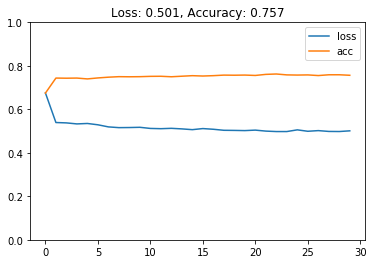

In [19]:
ADAMAX = optimizers.Adamax(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)
# Accuracy with ADAMAX at 0.944, loss at 0.153, F1 Score at 0.5222337125129266

ADAM = optimizers.Adam(lr = 0.01)
# Accuracy with ADAM at 0.945, loss at 0.146, F1 Score at 0.517427589592538

ADADELTA = optimizers.Adadelta(lr = 1.0, rho = 0.95)
# Accuracy with ADADELTA at , loss at 0.155, F1 Score at 0.506652474720596

ANN_model = Sequential()
ANN_model.add(Dense(16, input_shape = (X.shape[1],), activation = 'relu'))
ANN_model.add(Dense(32, activation = 'relu'))
ANN_model.add(Dense(32, activation = 'relu'))
ANN_model.add(Dense(3, activation = 'softmax'))

ANN_model.compile(optimizer = ADAM, loss = 'categorical_crossentropy', metrics = ['accuracy'])

ANN_history = ANN_model.fit(X_Train, y_Train, verbose = 1, epochs = 30)
plot_loss_accuracy(ANN_history)

Confusion matrix, without normalization
[[ 7575  3057   557]
 [  456 19420  3473]
 [  196  4493 14995]]


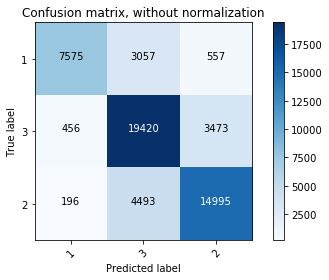

In [20]:
# Predict the y values and plot confusion matrix

y_pred = ANN_model.predict(X_test)
cnf_matrix = confusion_matrix(y_test.argmax(axis = 1), y_pred.argmax(axis = 1))
np.set_printoptions(precision = 2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['1','3', '2'],
                      title='Confusion matrix, without normalization')

In [21]:
#extracting true_positives, false_positives, true_negatives, false_negatives

fp = cnf_matrix.sum(axis = 0) - np.diag(cnf_matrix)  
fn = cnf_matrix.sum(axis = 1) - np.diag(cnf_matrix)
tp = np.diag(cnf_matrix)
tn = cnf_matrix.sum() - (fp + fn + tp)
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

True Negatives:  [42381 23323 30508]
False Positives:  [ 652 7550 4030]
False Negatives:  [3614 3929 4689]
True Positives:  [ 7575 19420 14995]


In [22]:
# sensitivity, hit rate, recall, or true positive rate
tpr = tp/(tp+fn)
# specificity or true negative rate
tnr = tn/(tn+fp) 
# precision or positive predictive value
ppv = tp/(tp+fp)
# negative predictive value
npv = tn/(tn+fn)
# fall out or false positive rate
fpr = fp/(fp+tn)
# false negative rate
fnr = fn/(tp+fn)
# false discovery rate
fdr = fp/(tp+fp)
# overall accuracy
acc = (tp+tn)/(tp+fp+fn+tn)

In [23]:
"""
(2*ppv*tpr)/(ppv+tpr)
"""
y_pred = np.rint(y_pred)
f1_score(y_test, y_pred, average = 'weighted')

0.723806088952613

In [24]:
test_predictions = ANN_model.predict(test_data)
labels = np.argmax(test_predictions, axis = -1)
submission_df = pd.DataFrame({
                  "Loan_ID": loan_id, 
                  "Interest_Rate": labels})

In [25]:
submission_df['Interest_Rate'].replace(to_replace = [0, 1, 2], value = [1, 2, 3], inplace = True)

In [26]:
submission_df.to_csv('final_submission.csv', index = False)